In [508]:
#automatically reload stuff
%reload_ext autoreload
%autoreload 2
from SymptomPreprocessing import *
from SpatialPreprocessing import *
import Preprocessing as P
import Cluster
import Metrics
import re
import RPorts
import Utils
from warnings import simplefilter 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import f_classif, f_regression
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef
from datetime import datetime
import statsmodels.api as sm
from scipy.stats import chi2

simplefilter(action='ignore')
pd.set_option('display.max_rows', 1000)

In [206]:
def timestamp():
    return datetime.now().strftime('%Y%d%H%M%S%f')
for i in range(10):
    print(timestamp())

202228154026461887
202228154026461927
202228154026461939
202228154026461949
202228154026461964
202228154026461975
202228154026461984
202228154026461993
202228154026462002
202228154026462115


In [2]:
rds = RadDataset()
rds.get_value_array(rds.dvh_df.columns,as_df=True)

spellchecking...
renaming things
filtering pateints
adding nan values for missing organs
adding histograms


,Esophagus_D99,Esophagus_V80,Esophagus_D55,Esophagus_D20,Esophagus_V45,Esophagus_V25,Esophagus_D98,Esophagus_mean_dose,Esophagus_V55,Esophagus_D10,...,Glottic_Area_D95,Glottic_Area_D2,Glottic_Area_D40,Glottic_Area_D50,Glottic_Area_D90,Glottic_Area_V70,Glottic_Area_D15,Glottic_Area_D25,Glottic_Area_D45,Glottic_Area_D5
id,,,,,,,,,,,,,,,,,,,,,
2.0,3.500000,0.0,36.031250,47.093750,23.890625,82.937500,4.011719,35.720554,1.211914,51.625000,...,15.929688,48.562500,25.250000,22.437500,16.500000,0.000000,36.093750,30.906250,23.953125,44.968750
6.0,1.870117,0.0,36.968750,42.781250,9.570312,72.437500,2.160156,30.499019,0.000000,44.968750,...,28.734375,45.031250,32.937500,32.312500,29.343750,0.000000,36.843750,34.656250,32.593750,43.125000
7.0,0.010002,0.0,27.515625,35.250000,0.000000,58.031250,0.010002,22.765716,0.000000,37.625000,...,27.500000,31.312500,29.390625,28.906250,27.703125,0.000000,30.421875,29.906250,29.062500,30.968750
8.0,3.830078,0.0,15.156250,31.203125,0.000000,44.750000,4.199219,19.083992,0.000000,32.156250,...,7.308594,28.234375,14.078125,13.812500,7.859375,0.000000,27.156250,15.312500,14.000000,27.984375
9.0,12.820312,0.0,31.546875,46.031250,22.078125,73.375000,13.757812,33.666962,4.335938,51.437500,...,5.750000,31.578125,17.203125,13.179688,5.820312,0.000000,25.000000,21.531250,15.671875,29.468750
10.0,3.419922,0.0,31.234375,42.000000,7.031250,60.843750,3.560547,27.220497,0.000000,44.218750,...,28.234375,66.562500,44.093750,40.843750,29.406250,0.000000,56.750000,53.656250,42.343750,65.875000
11.0,6.058594,0.0,7.839844,25.093750,0.000000,20.859375,6.109375,13.436690,0.000000,26.156250,...,8.453125,34.250000,12.859375,11.851562,8.773438,0.000000,18.593750,18.234375,12.609375,20.515625
12.0,0.010002,0.0,1.219727,2.460938,0.000000,0.000000,0.010002,1.584915,0.000000,3.279297,...,1.549805,33.000000,7.421875,2.750000,1.629883,0.000000,18.640625,12.781250,6.101562,28.093750
13.0,0.010002,0.0,38.343750,41.406250,0.000000,75.875000,0.020004,31.537254,0.000000,42.218750,...,6.550781,26.937500,11.210938,10.570312,7.031250,0.000000,17.171875,15.046875,10.796875,23.343750


In [9]:
def add_dose_limits(df,organ_list=None):
    #dose limits as binary values from https://applications.emro.who.int/imemrf/Rep_Radiother_Oncol/Rep_Radiother_Oncol_2013_1_1_35_48.pdf
    #not inlcudeing other stuff like eyes at this time
    #also, my max dose is weird so I'm using V10 for that because I feel like that makes sense
    #using the 
    if organ_list is None:
        organ_list = Const.organ_list[:]
    df = df.copy()
    original_cols = set(df.columns)
    getval = lambda organ,param: df[param].apply(lambda x: x[organ_list.index(organ)])
    get_lr_val = lambda organ,param: np.maximum(getval('Lt_'+organ,param),getval('Rt_'+organ,param))
    
    maxdose_var = 'max_dose'
    #symptomatic necrosis
    df['Brainstem_limit'] = (getval('Brainstem','D2') > 59) | (getval('Brainstem','D99') > 54)
    
    #myelopathy
    df['Spinal_Cord_limit'] = getval('Spinal_Cord',maxdose_var) > 50
    
    #xerostomia. >25 for 1 or >20 for both
    df['Parotid_Gland_limit'] = (get_lr_val('Parotid_Gland','mean_dose') > 20) | (getval('Lt_Parotid_Gland','mean_dose') > 25) | (getval('Rt_Parotid_Gland','mean_dose') > 25)
    
    #there is 50 for PEG tube and 60 for aspiration so i'll do 50
    for o in ['IPC','MPC',"SPC"]:
        df[o+"_limit"] = getval(o,'mean_dose') > 50
        df[o+"_limit2"] = getval(o,'mean_dose') > 60
    
    #ORN?
    df['Mandible_limit'] = getval('Mandible',maxdose_var) > 70
    
    #edema
    df['Larynx_limit'] = getval('Larynx','V50') > 27
    
    #Nerve damage
    df['Brachial_Plexus_limit'] = get_lr_val('Brachial_Plexus',maxdose_var) > 60
    
    #Esophagitus
    elimits = [('V35',50),('V50',40),('V70',20),('V60',30)]
    df['Esophagus_limit'] = np.stack([(getval('Esophagus',v) > lim) for v,lim in elimits]).sum(axis=0) > 0
    
#     print(df[[c for c in df.columns if  c not in original_cols]].sum())
    return df

def rds_to_df(rds):
    sd_df = P.get_merged_symp_dose_df(rds,roll_up=True)
    sd_df = P.get_symptoms_max(sd_df)
    sd_df =  P.add_sd_dose_clusters(sd_df)
    sd_df = P.add_sd_symptom_clusters(sd_df)
    sd_df = add_dose_limits(sd_df)
    return sd_df

sddf = rds_to_df(rds)
sddf = P.add_sd_dose_clusters(sddf)
sddf

before drop count 823
after drop count 535
error (%) 0.7424412531907885
[('severe_6wk_symptoms', 0.009345794392523364), ('severe_late_symptoms', 0.014953271028037384), ('moderate_6wk_symptoms', 0.052336448598130844), ('moderate_late_symptoms', 0.04672897196261682), ('mild_6wk_symptoms', 0.19626168224299065), ('mild_late_symptoms', 0.17009345794392525)]
dose ids: 484 syptom ids: 535 merged ids: 349
using default similarity


,D10,D15,D2,D20,D25,D30,D35,D40,D45,D5,...,IPC_limit,IPC_limit2,MPC_limit,MPC_limit2,SPC_limit,SPC_limit2,Mandible_limit,Larynx_limit,Brachial_Plexus_limit,Esophagus_limit
id,,,,,,,,,,,,,,,,,,,,,
7,"[37.625, 37.15625, 66.3125, 60.3125, 49.4375, ...","[36.5625, 36.75, 64.0625, 59.96875, 48.375, 49...","[39.96875, 38.0625, 71.8125, 60.90625, 52.1562...","[35.25, 36.34375, 62.71875, 59.71875, 47.34375...","[34.0625, 35.90625, 61.53125, 59.40625, 46.562...","[33.125, 35.5, 60.34375, 59.1875, 45.6875, 43....","[32.28125, 35.03125, 59.03125, 58.90625, 44.75...","[31.609375, 34.625, 57.71875, 58.625, 43.96875...","[30.84375, 34.1875, 56.40625, 58.3125, 43.1875...","[38.6875, 37.625, 71.0625, 60.625, 50.75, 53.8...",...,True,False,True,False,True,False,True,False,True,False
8,"[32.15625, 32.0625, 65.375, 56.6875, 22.5, 31....","[31.703125, 31.109375, 63.34375, 55.75, 21.312...","[33.4375, 34.09375, 68.75, 58.28125, 33.6875, ...","[31.203125, 30.25, 61.34375, 54.5625, 17.84375...","[30.609375, 29.40625, 60.03125, 52.375, 14.367...","[29.9375, 28.390625, 59.5, 50.5625, 13.140625,...","[28.96875, 27.453125, 58.96875, 49.46875, 11.7...","[27.1875, 26.46875, 58.53125, 48.59375, 11.203...","[24.875, 25.453125, 58.125, 48.0, 10.9609375, ...","[32.78125, 33.125, 67.375, 57.65625, 25.3125, ...",...,True,False,True,True,True,True,True,True,True,False
9,"[51.4375, 27.515625, 51.4375, 51.4375, 18.6875...","[48.59375, 26.671875, 48.59375, 48.59375, 15.0...","[56.65625, 29.5625, 56.65625, 56.65625, 27.312...","[46.03125, 25.9375, 46.03125, 46.03125, 13.0, ...","[43.53125, 25.296875, 43.53125, 43.53125, 11.3...","[41.28125, 24.671875, 41.28125, 41.28125, 10.3...","[39.15625, 24.046875, 39.15625, 39.15625, 9.82...","[37.0, 23.359375, 37.0, 37.0, 9.4609375, 11.28...","[35.125, 22.625, 35.125, 35.125, 9.109375, 9.3...","[54.46875, 28.625, 54.46875, 54.46875, 23.3125...",...,False,False,False,False,False,False,False,False,False,False
10,"[44.21875, 35.625, 55.9375, 64.75, 52.84375, 5...","[43.1875, 34.28125, 54.3125, 62.6875, 50.78125...","[47.84375, 39.21875, 58.15625, 68.5625, 57.406...","[42.0, 33.125, 52.84375, 59.53125, 48.875, 46....","[40.71875, 32.34375, 51.4375, 58.65625, 47.343...","[38.90625, 31.625, 50.0, 58.3125, 46.5, 44.687...","[36.875, 30.921875, 48.75, 57.8125, 46.125, 43...","[35.5625, 30.1875, 47.6875, 56.6875, 45.75, 43...","[33.96875, 29.4375, 46.4375, 55.03125, 45.3125...","[45.71875, 37.34375, 57.46875, 66.6875, 55.25,...",...,True,True,True,True,True,True,True,True,True,False
11,"[26.15625, 31.984375, 57.125, 45.40625, 29.265...","[25.625, 31.359375, 56.875, 45.15625, 26.48437...","[27.5625, 33.25, 57.65625, 45.84375, 36.75, 44...","[25.09375, 30.71875, 56.65625, 45.0, 22.828125...","[22.625, 30.15625, 56.46875, 44.8125, 19.85937...","[19.75, 29.65625, 56.21875, 44.625, 17.640625,...","[14.1484375, 29.234375, 55.9375, 44.46875, 15....","[11.09375, 28.84375, 55.6875, 44.21875, 14.210...","[9.1015625, 28.46875, 55.4375, 44.03125, 12.53...","[26.8125, 32.71875, 57.40625, 45.625, 33.03125...",...,True,False,True,False,True,False,True,False,False,False
13,"[42.21875, 29.625, 48.6875, 60.46875, 19.5, 41...","[41.8125, 29.046875, 48.15625, 58.34375, 14.52...","[43.0, 31.0, 54.09375, 70.625, 35.5625, 51.0, ...","[41.40625, 28.46875, 47.8125, 56.4375, 12.9921...","[41.03125, 27.859375, 47.59375, 54.5, 10.29687...","[40.65625, 27.234375, 47.375, 52.78125, 9.3593...","[40.3125, 26.359375, 47.1875, 50.9375, 8.67187...","[39.90625, 25.09375, 47.0, 49.4375, 8.3984375,...","[39.4375, 24.015625, 46.8125, 48.21875, 7.6484...","[42.65625, 30.375, 52.125, 65.375, 25.234375, ...",...,False,False,True,True,True,True,True,False,True,True
15,"[44.90625, 33.28125, 57.71875, 47.75, 43.625, ...","[44.0, 32.75, 57.21875, 47.5625, 40.40625, 48....","[46.5, 34.9375, 58.71875, 48.375, 46.875, 51.9...","[43.0625, 32.28125, 56.625, 47.375, 37.15625, ...","[42.03125, 31.8125, 56.03125, 47.25, 31.1875, ...","[41.03125, 31.046875, 55.1875, 47.125, 21.9843...","[4

In [147]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, GradientBoostingRegressor, AdaBoostRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

def add_pscore(df,treatment,covariates,
               model=None,
               use_cv=False):
    x = df[treatment].values
    z = np.stack(df[covariates].apply(lambda x: np.stack([np.array(xx) for xx in x])).values)
    pp = predict_propensity(x,z,model=model,use_cv=use_cv)
    df = df.copy()
    df.loc[:,'propensity'] = pp['pscore']
    return df

def predict_cv(model,x,y,cvsize=None):
    #currently leave-one-out
    predictions = []
    y = y.reshape(-1,1)
    if cvsize == None:
        cvsize = int(x.shape[0]*.1)+1
    nsteps = int(np.ceil(x.shape[0]/cvsize))
    start = 0
    for i in range(nsteps):
        stop = min(start + cvsize,x.shape[0])
        test_idx = np.arange(start,stop)
        x_train = np.delete(x, test_idx,axis=0)
        x_test = x[test_idx]
        y_train = np.delete(y,test_idx)
        y_test = y[test_idx]
        
        if x_test.ndim < 2:
            x_test = x_test.reshape(1,-1)
        model.fit(x_train,y_train)
        
        ypred = model.predict_proba(x_test)
        predictions.append(ypred)
        
        start=stop
    ypred = np.concatenate(predictions)
    ypred = ypred.reshape(x.shape[0],-1)
    return ypred

def get_metrics(y,ypred,model):
    #binary
    squeeze = lambda x: np.argmax(x,axis=1).ravel()
#     y_true = pd.get_dummies(y.loc[:,model.classes_]).values#one-hot encoe
    y_true = y.reshape(-1,1)#binary output shoud work like this idk
    roc = roc_auc_score(y_true,ypred[:,1],average='weighted')
    accuracy = accuracy_score(y_true, squeeze(ypred))
    fscore = f1_score(y_true,squeeze(ypred))
    return {'roc': roc, 'accuracy': accuracy,'fscore':fscore}

def predict_propensity(x,z,model=None,use_cv=False,calibrate=False):
    #assumes binary outcome
    if model is None:
        model = RandomForestClassifier(n_estimators=500,
                                       max_depth=4,
                                       class_weight='balanced')
    if calibrate:
        model = CalibratedClassifierCV(base_estimator=model)
    if use_cv:
        predictions = predict_cv(model,z,x)
    else:
        predictions = model.fit(z,x)
        predictions = model.predict_proba(z)
    model.fit(z,x)
    results  = {'pscore': predictions[:,1], "model": model}
    metrics = get_metrics(x,predictions,model)
    results['metrics'] = metrics
    return results

def add_weights(cdf,treatment,covariates,model=None):
    if 'propensity' not in cdf.columns:
        cdf = add_pscore(cdf.copy(), treatment, covariates,model=model)
    def get_weight(row):
        if row[treatment] == 1:
            weight = 1/row['propensity']
        else:
            weight = 1/(1-row['propensity'])
        return weight
    cdf.loc[:,'weights'] = cdf.apply(get_weight,axis=1)
    return cdf
    
def get_dr_ate(treatment,outcome,confounders,
               weights = True,
               covariates = None, 
               p_model=None,
               dr_model=None,
               use_proba=True,
               min_propensity=.01,
               calibrate=True,
              ):
    try:
        #this is giving me weird results
        if p_model is None:
    #         p_model = LogisticRegression(class_weight='balanced')
            p_model = RandomForestClassifier(class_weight='balanced')
        if dr_model is None:
            dr_model = LogisticRegression(class_weight='balanced')
            
        if calibrate:
            max_cv = outcome.sum()
            if max_cv < 3:
                cv = max_cv -1
            else:
                cv=5
            dr_model = CalibratedClassifierCV(base_estimator=dr_model,cv=cv)
            p_model = CalibratedClassifierCV(base_estimator=p_model,cv=cv)
        cdf = pd.DataFrame({'treatment':treatment,'outcome':outcome})
        confounder_cols = ['confounder_'+str(i) for i in range(confounders.shape[1])]
        for i,col in enumerate(confounder_cols):
            cdf[col] = confounders[:,i].tolist()

        if 'weights' not in cdf.columns:
            cdf = add_weights(cdf.copy(), 
                              'treatment', 
                              confounder_cols,
                              model=p_model)   
        cdf = cdf[(cdf['propensity'] >= min_propensity) | (cdf.treatment.astype('bool'))]
        cdf.propensity = cdf.propensity.apply(lambda x: np.clip(x,.01,.99))
        y = cdf['outcome'].values.astype('bool')
        input_x = cdf[['treatment']+confounder_cols]

        xcols = ['treatment']+confounder_cols
        x_1 = cdf[xcols]
        x_0 = cdf[xcols]

        x_1.loc[:,'treatment'] = 1
        x_0.loc[:,'treatment'] = 0
        
        dr_model.fit(input_x,y)
        y_1 = dr_model.predict_proba(x_1).astype('float')[:,-1]
        y_0 = dr_model.predict_proba(x_0).astype('float')[:,-1]
        
        if not use_proba:
            y_1 = (y_1 > .5).astype('float')
            y_0 = (y_0 < .5).astype('float')
        cdf['y_0'] = y_0#[:,-1]
        cdf['y_1'] = y_1#[:,-1]


        def dr1(row):
            #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3070495/ table 1
            n1 = row['outcome']*row['treatment']
            n2 = row['y_1']*(row['treatment']-row['propensity'])
            prop = row['propensity']
            return (n1 - n2)/(prop)

        def dr0(row):
            #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3070495/ table 1
            n1 = row['outcome']*(1-row['treatment'])
            n2 = row['y_0']*(row['treatment'] -row['propensity'])
            return (n1 + n2)/(1-row['propensity'])
        
        cdf['d1'] = cdf.apply(dr1,axis=1)
        cdf['d0'] = cdf.apply(dr0,axis=1)

        ate = cdf['d1'].mean() - cdf['d0'].mean()
        return ate#, cdf.drop(confounder_cols,axis=1)
    except Exception as e:
        print('error in doubly robust ate', e)
        return -1

    
def get_iptw_ate(treatment,outcome,confounders,
               weights = True,
               covariates = None, 
               p_model=None,
               use_proba=True,
               min_propensity=.001,
               calibrate=True,
              ):
    try:
        if p_model is None:
    #         p_model = LogisticRegression(class_weight='balanced')
            p_model = RandomForestClassifier(class_weight='balanced')
        if calibrate:
            p_model = CalibratedClassifierCV(base_estimator=p_model)
        cdf = pd.DataFrame({'treatment':treatment,'outcome':outcome})
        confounder_cols = ['confounder_'+str(i) for i in range(confounders.shape[1])]
        for i,col in enumerate(confounder_cols):
            cdf[col] = confounders[:,i].tolist()

        if 'weights' not in cdf.columns:
            cdf = add_weights(cdf.copy(), 
                              'treatment', 
                              confounder_cols,
                              model=p_model)   
        cdf = cdf[(cdf['propensity'] >= min_propensity) | (cdf.treatment.astype('bool'))]
        treat= cdf[cdf['treatment']]
        con = cdf[~cdf['treatment']]
        y_1 = (treat['outcome'] * treat['weights']).sum()/treat.shape[0]
        y_0 = (con['outcome'] * con['weights']).sum()/con.shape[0]
        return y_1 - y_0
    except Exception as e:
        print('error in iptw ate', e)
        return -1

def get_matching_ate(treatment,outcome,confounders,
               weights = True,
               covariates = None, 
               p_model=None,
               use_proba=True,
               min_propensity=.001,
               replacement = False,
               calibrate=True,
              ):
    try:
        if p_model is None:
            p_model = RandomForestClassifier(class_weight='balanced')
        if calibrate:
            p_model = CalibratedClassifierCV(base_estimator=p_model)
        cdf = pd.DataFrame({'treatment':treatment,'outcome':outcome})
        confounder_cols = ['confounder_'+str(i) for i in range(confounders.shape[1])]
        for i,col in enumerate(confounder_cols):
            cdf[col] = confounders[:,i].tolist()

        if 'propensity' not in cdf.columns:
            cdf = add_pscore(cdf.copy(), 
                              'treatment', 
                              confounder_cols,
                              model=p_model)   
        cdf = cdf[(cdf['propensity'] >= min_propensity) | (cdf.treatment.astype('bool'))]
        treat= cdf[cdf['treatment']]
        control = cdf[~cdf['treatment']]
        matches = []
        for i,row in treat.iterrows():
            con = control.copy()
            con['pdiff'] = con['propensity'].apply(lambda x: np.abs(x - row['propensity']))
            matchdf = con[con.pdiff == con.pdiff.min()]
            if not replacement:
                control = control.drop(matchdf.index)
                if control.shape[0] < 2:
                    break
            matches.append(matchdf)
        matched_control= pd.concat(matches,axis=0)
        standard_ate = (treat['outcome'].mean() - matched_control['outcome'].mean())
        return standard_ate
    except Exception as e:
        print('error in matching ate', e)
        return -1
    

    
treatment = sddf['dose_clusters'].apply(lambda x: x == 3).values
outcome = sddf['t4'].values
confounders = sddf[['n3','old']].values
print(treatment.shape,outcome.shape,confounders.shape)
get_iptw_ate(treatment,outcome,confounders)

(349,) (349,) (349, 2)


0.3543621427173251

In [780]:
sddf[sddf.age.isnull()]

,D10,D15,D2,D20,D25,D30,D35,D40,D45,D5,...,IPC_limit,IPC_limit2,MPC_limit,MPC_limit2,SPC_limit,SPC_limit2,Mandible_limit,Larynx_limit,Brachial_Plexus_limit,Esophagus_limit
id,,,,,,,,,,,,,,,,,,,,,
691,"[51.4375, 51.4375, 51.4375, 51.4375, 51.4375, ...","[48.59375, 48.59375, 48.59375, 48.59375, 48.59...","[56.65625, 56.65625, 56.65625, 56.65625, 56.65...","[46.03125, 46.03125, 46.03125, 46.03125, 46.03...","[43.53125, 43.53125, 43.53125, 43.53125, 43.53...","[41.28125, 41.28125, 41.28125, 41.28125, 41.28...","[39.15625, 39.15625, 39.15625, 39.15625, 39.15...","[37.0, 37.0, 37.0, 37.0, 37.0, 0.0200042724609...","[35.125, 35.125, 35.125, 35.125, 35.125, 0.020...","[54.46875, 54.46875, 54.46875, 54.46875, 54.46...",...,False,False,False,False,False,False,False,False,False,False


In [921]:
def get_aggregate_outcome(df,symptoms,dates,aggfunc=None):
    if aggfunc is None:
        aggfunc = np.max
    df = df.copy()
    date_idxs = [i for i,d in enumerate(df.dates.iloc[0]) if d in dates]
#     print('dates',dates,date_idxs)
    s_array = np.zeros((df.shape[0],len(symptoms)))
    for col,symptom in enumerate(symptoms):
        if 'symptoms_'+symptom not in df.columns:
            print('missing',symptom)
        svals = df['symptoms_'+symptom].apply(lambda x: np.max([x[i] for i in date_idxs]) )
        s_array[:,col] = svals
    res = np.apply_along_axis(aggfunc,1,s_array)
    return res

def add_outcomes(df,symptoms,dates,aggfunc=None):
    vals = get_aggregate_outcome(df,symptoms,dates,aggfunc)
    name = '_'.join(symptoms) + '_' + '-'.join([str(d) for d in dates])
    df = df.copy()
    df[name] = vals
    return df

def filter_confounders(confounders,treatment,outcome,max_pval = .1):
    #gvien a list of covariates, get true confounders based on correlation vis f-test
    #only returns covariates with a correlation below max_pval
    #if none, returns the most correlated value so i'ts not an empty set
    xz = f_classif(confounders,treatment)[1]
    xy = f_classif(confounders,outcome)[1]
    max_p = np.maximum(xz,xy)
    #if none below threshold, take the minimum pvalue instead
    max_pval = max(np.min(max_p),max_pval)
    valid = max_p <= max_pval
    #assumes confounders is a df for now
    return confounders.iloc[:,valid]

def aggregate_ate_results(res):
    agg_by = [c for c in res.columns if '_ate' not in c]
    ate_cols = [c for c in res.columns if '_ate' in c]
    new_results = []
    for i, subdf in res.groupby(agg_by):
        entry = {}
        for name, val in zip(agg_by,i):
            entry[name] = val
        for atetype in ate_cols:
            quants = subdf[atetype].quantile([.05,.5,.95]).values
            is_negative = np.sign(np.max(quants)) < 0
            is_positive = np.sign(np.min(quants)) > 0
            signficiant = is_negative or is_positive
            entry[atetype + '_05'] = quants[0]
            entry[atetype + '_median'] = quants[1]
            entry[atetype + '_95'] = quants[2]
            entry[atetype + '_sig'] = signficiant
            entry[atetype + '_positive'] = is_positive
        new_results.append(entry)
    return pd.DataFrame(new_results).sort_values(['dr_ate_05'],ascending=False)

def var_tests(df, testcol, ycol,xcols, 
#              boolean=True,
             regularize = True,
             scale=True):
    df = df.fillna(0)
    y = df[ycol]
    if y.max() > 1:
        y = y/y.max()
    if testcol not in xcols:
        xcols = xcols + [testcol]
    x = df[xcols].astype(float)
    if regularize:
        for col in xcols:
            x[col] = (x[col] - x[col].mean())/(x[col].std()+ .01)
    if scale:
        for col in xcols:
            x[col] = (x[col] - x[col].min())/(x[col].max() - x[col].min())
    for col in xcols:
        if x[col].std() < .00001:
#             print(col)
            x = x.drop(col,axis=1)
    x2 = x.copy()
    x2 = x2.drop(testcol,axis=1)
    boolean = (df[ycol].max() <= 1) and (len(df[ycol].unique()) <= 2)
    if boolean:
        model = sm.Logit
        method = 'bfgs'
        
    else:
        model = sm.OLS
        method= 'qr'
    logit = model(y,x)
    logit_res = logit.fit(maxiter=500,
                          disp=False,
                          method=method,
                         )
    
    logit2 = model(y,x2)
    logit2_res = logit2.fit(maxiter=500,
                            disp=False,
                            method=method,
                           )
    
    llr_stat = 2*(logit_res.llf - logit2_res.llf)
    llr_p_val = chi2.sf(llr_stat,1)
    
    aic_diff = logit_res.aic - logit2_res.aic
    bic_diff = logit_res.bic - logit2_res.bic
    
    results = {
        'ttest_pval': logit_res.pvalues[testcol],
        'ttest_tval': logit_res.tvalues[testcol],
        'lrt_pval': llr_p_val,
        'aic_diff': aic_diff,
        'bic_diff': bic_diff
    }
    return results

def multi_var_tests(df, testcols, ycol,xcols, 
#              boolean=True,
             regularize = True,
             scale=True):
    df = df.fillna(0)
    y = df[ycol]
    if y.max() > 1:
        y = y/y.max()
    xcols = list(set(xcols).union(set(testcols)))
    x = df[xcols].astype(float)
    if regularize:
        for col in xcols:
            x[col] = (x[col] - x[col].mean())/(x[col].std()+ .01)
    if scale:
        for col in xcols:
            x[col] = (x[col] - x[col].min())/(x[col].max() - x[col].min())
    for col in xcols:
        if x[col].std() < .00001:
#             print(col)
            x = x.drop(col,axis=1)
    x2 = x.copy()
    x2 = x2.drop(testcols,axis=1)
    boolean = (df[ycol].max() <= 1) and (len(df[ycol].unique()) <= 2)
    if boolean:
        model = sm.Logit
        method = 'bfgs'
        
    else:
        model = sm.OLS
        method= 'qr'
    logit = model(y,x)
    logit_res = logit.fit(maxiter=500,
                          disp=False,
                          method=method,
                         )
    
    logit2 = model(y,x2)
    logit2_res = logit2.fit(maxiter=500,
                            disp=False,
                            method=method,
                           )
    
    llr_stat = 2*(logit_res.llf - logit2_res.llf)
    llr_p_val = chi2.sf(llr_stat,len(testcols))
    
    aic_diff = logit_res.aic - logit2_res.aic
    bic_diff = logit_res.bic - logit2_res.bic
    
    results = {
        'lrt_pval': llr_p_val,
        'aic_diff': aic_diff,
        'bic_diff': bic_diff
    }
#     for testcol in testcols:
#         results['ttest_pval_' + str(testcol)]= logit_res.pvalues[testcol]
#         results['ttest_tval_' + str(testcol)]= logit_res.tvalues[testcol]
    return results

def get_stratification_metrics(y,ypred,model):
    #binary
    squeeze = lambda x: np.argmax(x,axis=1).ravel()
#     y_true = pd.get_dummies(y.loc[:,model.classes_]).values#one-hot encoe
    y_true = y.reshape(-1,1)#binary output shoud work like this idk
    roc = roc_auc_score(y_true,ypred[:,1],average='weighted')
    accuracy = accuracy_score(y_true, squeeze(ypred))
#     fscore = f1_score(y_true,squeeze(ypred))
    [precision,recall,fscore,support] = precision_recall_fscore_support(y_true,squeeze(ypred),average='binary')
    fbeta = lambda b: (1+b**2)*(precision*recall)/((b**2)*precision + recall)
    f_half = fbeta(.5)
    f2 = fbeta(2)
    matthews = matthews_corrcoef(y_true,squeeze(ypred))
    dor = (recall*precision)/((1-recall)*(1-precision))
    results=  {
        'roc': roc, 
        'mcc': matthews,
        'dor': dor,
        'accuracy': accuracy,
        'precision': precision,
        'recall':recall,
        'f1': fscore,
        'f_half': f_half,
        'f2': f2,
    }
    return results

class ClusterTester():
    
    def __init__(self,df,
                 cluster_organs, 
                 n_clusters=4, 
                 symptoms=None,
                 cluster_features=None,
                 outcome_dates=None,
                 default_confounders=None,
                 agg_type='max',
                 **kwargs,
                ):
        
        self.cluster_organs = cluster_organs
        self.n_clusters = n_clusters
        
        if symptoms is None:
            symptoms = ['drymouth']
        self.symptoms = symptoms
        
        if cluster_features is None:
            cluster_features = ['V35','V40','V45','V50','V55','V60']
        self.cluster_features = cluster_features
        
        if outcome_dates is None:
            outcome_dates = [13,33]
        self.outcome_dates = outcome_dates
        
        if agg_type == 'mean' or agg_type == 'average':
            self.agg_func = np.nanmean
        else:
            self.agg_func = np.nanmax
            
            
        if default_confounders is None:
            default_confounders = ['t4','t3','n_severe','hpv','Parotid_Gland_limit']
        self.default_confounders = default_confounders
        df = df.copy()
        df = self.filter_df(df)
        self.df = df
        self.cluster_df=None
        
    def get_cluster_df(self,resample=False):
        df = self.df.copy()
        if resample:
            df = df.sample(frac=1)
        if self.cluster_df is None and (not resample):
            df = P.add_sd_dose_clusters(df,
                                features=self.cluster_features,
                                organ_subset=self.cluster_organs,
                                n_clusters = self.n_clusters,
                               )
            self.cluster_df = df
        return self.cluster_df.copy()
    
    def get_outcome(self,threshold=5):
        outcome = get_aggregate_outcome(self.df,self.symptoms,self.outcome_dates,aggfunc=self.agg_func)
        if threshold > 0:
            outcome = outcome >= threshold
        return outcome
    
    def df_with_outcome(self,key='outcome',threshold=5):
        df = self.df.copy()
        df[key] = self.get_outcome(threshold=threshold)
        return df
        
    def filter_df(self,df):
        keywords = ['_original','_max_','_6wk_symptoms','_late_symptoms']
        for keyword in keywords:
            to_drop = [col for col in df.columns if keyword in col]
            df = df.drop(to_drop,axis=1)
        return df
    
    def extract_dose_vals(self,organ_list,features=None,as_df=True):
        oidxs = [Const.organ_list.index(o) for o in organ_list if o in Const.organ_list]
        
        if features is None:
            features = self.cluster_features
        df = self.df.copy()
        vals = []
        names = []
        for f in features:
            for (oname, oidx) in zip(organ_list, oidxs):
                values = df[f].apply(lambda x: x[oidx])
                vals.append(values.values.reshape((-1,1)))
                names.append(f+'_'+oname)
        vals = np.hstack(vals)
        if as_df:
            vals = pd.DataFrame(vals,columns=names,index=self.df.index)
        return vals
    
    def extract_confounders(self, 
                            categorical_confounders=None, 
                            use_dose_confounders=False,
                            organ_confounders=None, 
                            organ_confounder_features=None,
                           ):
        if categorical_confounders is None:
            categorical_confounders = [dc for dc in self.default_confounders if dc != 'age']
            if 'age' in self.default_confounders:
                categorical_confounders = categorical_confounders + ['old']
        categorical_confounders = [c for c in categorical_confounders if c in self.df.columns]
        confounders = self.df[categorical_confounders].astype('float')
        if organ_confounders is None and use_dose_confounders:
            organ_confounders = [o for o in Const.organ_list if o not in self.cluster_organs]
        if organ_confounders is not None:
            if organ_confounder_features is None:
                organ_confounder_features = self.cluster_features
            dose_confounders = self.extract_dose_vals(
                organ_confounders,
                features=organ_confounder_features)
            confounders = pd.concat([dose_confounders,confounders],axis=1)
        return confounders
    
    def resample_df(self):
        df = self.df.copy().sample(frac=1)
        
    def get_ate(self,
                use_iptw=True,
                use_dr=True,
                use_matching=False,
                thresholds=[3,5,7],
                use_dose_confounders=True,
                n_iters = 10,
                confounder_pval_filter=.1,
                skip_first = True,
                aggregate = True,
                **kwargs):
        resample_df = (n_iters > 1)
        results = []
        if not resample_df:
            df = self.get_cluster_df(resample=False)
        for n in range(n_iters):
            if resample_df:
                df = self.get_cluster_df(resample = True)
            clustvals = df['dose_clusters'].unique()
            confounders = self.extract_confounders(
                use_dose_confounders=use_dose_confounders,
                **kwargs)
            
            for c in clustvals:
                if c == np.min(clustvals) and skip_first:
                    continue
                treatment = (df['dose_clusters'] == c).astype(bool).values.ravel()
                for threshold in thresholds:
                    outcome = self.get_outcome(threshold=threshold).ravel()
                    if confounder_pval_filter < 1:
                        temp_confounders = filter_confounders(confounders,treatment,outcome,
                                                             max_pval=confounder_pval_filter).values
                    else:
                        temp_confounders = confounders.values
                    ate_entry = {
                        'threshold':threshold,
                        'cluster_value':c,
                    }
                    if use_iptw:
                        iptw = get_iptw_ate(treatment,outcome,temp_confounders)
                        ate_entry['iptw_ate'] = iptw
                    if use_dr:
                        dr = get_dr_ate(treatment,outcome,temp_confounders)
                        ate_entry['dr_ate'] = dr
                    if use_matching:
                        matching = get_matching_ate(treatment,outcome,temp_confounders)
                        ate_entry['matching_ate'] = matching
                    print(ate_entry,end='\r')
                    results.append(ate_entry)
        results = pd.DataFrame(results)
        results = results.sort_values(['cluster_value','threshold'],kind='mergesort')
        if aggregate and n_iters > 1:
            results = aggregate_ate_results(results)
        return results
    
    def get_basic_correlation(self,n_iters = 1, cluster=None, threshold = 0):
        pvals = []
        odds = []
        #gets pvalue or odds ratio with optional bootstrapping
        #will use fisher exact is both cluster and outcome are boolean
        #cluster = None and threshold = 0 use categorical
        use_chi2 = (cluster==None) or threshold < 1
        for n in range(n_iters):
            resample = n_iters > 1
            df = self.get_inference_df(threshold=threshold,
                                       cluster=cluster)
            x = df['x']
            outcome = df['outcome']
            try:
                if use_chi2:
                    odds_ratio,pval = Metrics.vector_chi2(x,outcome)
                else:
                    odds_ratio, pval = Metrics.boolean_fisher_exact(x,outcome)
                pvals.append(pval)
                odds.append(odds_ratio)
            except Exception as e:
                print(e)
        return pvals, odds
    
    def get_base_correlation_df(self,n_iters=1,thresholds=None):
        #get pvalue correlations for all/individual clusters either as a linear thing
        #or with different threhsolds
        results = []
        clusters = [None] + [i for i in range(self.n_clusters)]
        #threshold = 0 will be 1-10 isntead of the boolean thing
        if thresholds is None:
            thresholds = [0,3,5,7]
        for thold in thresholds:
            for clust in clusters:
                pvals, odds = self.get_basic_correlation(cluster=clust,
                                                         threshold=thold,
                                                         n_iters=n_iters)
                for p,o in zip(pvals,odds):
                    entry = {
                        'threshold': thold,
                        'cluster': clust if clust is not None else -1,
                        'pval': p,
                        'effect_size': o,
                    }
                    results.append(entry)
        return pd.DataFrame(results)
    
    def get_inference_df(self,cluster=None,
                         threshold=0,
                         resample=False,
                         onehotify=False,
                         confounders=None):
        #I wrote this after the ate stuff so it won't update in that funcion call if you change this
        df = self.get_cluster_df(resample=resample)
        df['x'] = df['dose_clusters']
        if cluster is not None:
            df['x'] = df['dose_clusters'].apply(lambda x: x==cluster)
        df['outcome'] = self.get_outcome(threshold=threshold)
        to_keep = ['x','outcome']
        if confounders is not None:
            to_keep.extend(confounders)
        to_keep = [c for c in to_keep if c in df.columns]
        df = df[to_keep]
        if onehotify:
            ignore = ['outcome']
            for c in confounders:
                if len(df[c].unique() < 5):
                    ignore = ignore + [c]
            if cluster is not None:
                ignore = ignore + ['x']
            if len([c for c in df.columns if c not in ignore]) > 0:
                df = Utils.onehotify(df,ignore=ignore,drop_first=True)
        return df
    
    def get_lrt_correlations(self,confounders=None,
                             resample=False,
                             threshold=0,
                             use_individual_effects=True,
                             cluster=None):
        if confounders is None:
            confounders =self.default_confounders[:]
        df = self.get_inference_df(threshold=threshold,
                                   onehotify=True,
                                   cluster=cluster,
                                   resample=resample,
                                   confounders=confounders)
#         return df
        treatment = ['x']
        #this wouldn't work if you have aconfounder with a similar label idk
        confounders = [c for c in df.columns if np.any([cc in c for cc in confounders])]
        if cluster is None:
            treatment = [c for c in df.columns if 'x_' in c and c not in confounders]
        results = multi_var_tests(df.fillna(0),treatment,'outcome',confounders)
        #basically calculates pvalues when we don't include other clusters for each clusters
        #these currently use the smae name convention so it will replace the old values if future you don't change stuff
        #I think the other way doens't really make sense since clusters are redundant
        for t in treatment:
            vals =var_tests(df.fillna(0),t,'outcome',confounders)
            for k,v in vals.items():
                key = k+'_'+t
                results[key] = v
        return results
    
    def get_lrt_correlation_df(self,
                               thresholds=None,
                               confounder_list=None,
                               resample=False,
                               clusters=None):
        #get pvalue correlations for all/individual clusters either as a linear thing
        #or with different threhsolds
        results = []
        #because it does individual coefficients you doen't really need other clusters idk
        if clusters is None:
            clusters = [None]
        #threshold = 0 will be 1-10 isntead of the boolean thing
        if thresholds is None:
            thresholds = [0,3,5,7]
        if confounder_list is None:
            confounder_list = [self.default_confounders]
        for thold in thresholds:
            for clust in clusters:
                for confounders in confounder_list:
                    res = self.get_lrt_correlations(cluster=clust,
                                                             threshold=thold,
                                                         resample=resample,
                                                           confounders=confounders)
                    entry = {
                        'cluster': clust if clust is not None else -1,
                        'threshold':thold,
                        'confounders': confounders,
                    }
                    for k,v in res.items():
                        entry[k] = v
                    results.append(entry)
        return pd.DataFrame(results)
    
    def get_cv_auc(self,
                   confounders=None,
                   threshold=5,
                   cluster=None,
                   resample=False,
                   
                   model=None):
        if confounders is None:
            confounders =self.default_confounders
        df = self.get_inference_df(threshold=threshold,
                                   onehotify=True,
                                   cluster=cluster,
                                   resample=resample,
                                   confounders=confounders)
        treatment = ['x']
        
        confounders = [c for c in df.columns if np.any([cc in c for cc in confounders])]
        if cluster is None:
            treatment = [c for c in df.columns if 'x_' in c and c not in confounders]
        xcols = treatment+confounders
        y = df['outcome'].values
        if model is None:
            model = LogisticRegression(class_weight='balanced')
        scale = lambda x: (x - x.min())/(x.max()-x.min())
        for c in treatment+confounders:
            if df[c].dtype != bool:
                df[c] = scale(df[c].fillna(0))
        ypred = predict_cv(model,df[treatment+confounders].values,y)
        ypred_baseline = predict_cv(model,df[confounders].values,y)
        metrics = get_stratification_metrics(y,ypred,model)
        metrics_baseline = get_stratification_metrics(y,ypred_baseline,model)
        
        results = {}
        for k,v in metrics.items():
            results[k] = v
            baseline = metrics_baseline[k]
            if baseline is None:
                baseline = 0
            results[k+'_change'] = v - baseline
        return results
    
    def get_demographic_breakdown(self,cat_cols = None, cont_cols = None):
        df = self.get_cluster_df()
        if cat_cols is None:
            cat_cols = [
                'is_male','t_stage','n_stage','hpv',
                'ic','rt','chemotherapy','os'
            ]
        if cont_cols is None:
            cont_cols = [
                'age',
                'followup_days',
            ]
        results = {}
        for col in cat_cols:
            catdf = df[~df[col].isnull()]
            entrys = {}
            for clust, subdf in catdf.groupby('dose_clusters'):
                clust_entry = {}
                csize = subdf.shape[0]
                for vName, subsubdf in subdf.groupby(col):
                    count = subsubdf.shape[0]
                    clust_entry[vName] = str(count) + ' (' + str(np.round(count*100/csize,1)) + ')%'
                entrys[clust] = clust_entry
            edf = pd.DataFrame(entrys).T
            edf.index.name = 'cluster'
            results[col] = edf
        cont_results = {}
        def get_dist(vals):
            vals = vals.astype(float)
            [q5,median,q95] = vals.quantile([.05,.5,.95])
            mean = vals.mean()
            std = vals.std()
            ce = {
                'mean': mean,
                'std': std,
                'q5': q5,
                'median': median,
                'q95': q95,
            }
            return ce
        
        for col in cont_cols:
            tempdf = df[~df[col].isnull()]
            entrys = {}
            entrys['all'] = get_dist(tempdf[col])
            for clust, subdf in tempdf.groupby('dose_clusters'):
                clust_entry = get_dist(subdf[col])
                entrys[clust] = clust_entry
            edf = pd.DataFrame(entrys).T
            edf.index.name = 'cluster'
            results[col] = edf
        return results
            
ooi = [
    'Tongue',
    'Genioglossus_M',
    'Mylogeniohyoid_M',
#     'Extended_Oral_Cavity',
    'Rt_Parotid_Gland','Lt_Parotid_Gland',
    'Rt_Submandibular_Gland','Lt_Submandibular_Gland',
    'Rt_Ant_Digastric_M','Lt_Ant_Digastric_M',
      ]
n =4
ct = ClusterTester(sddf,
                   ooi,
                   n_clusters=n,
                   cluster_features=['V35','V40','V45','V50','V55'],
                  )
test = ct.get_demographic_breakdown()
for k,v in test.items():
    print(k)
    print(v)
    print('_________________')

is_male
              False         True
cluster                         
0          4 (7.7)%   48 (92.3)%
1          5 (6.0)%   78 (94.0)%
2        14 (20.9)%   53 (79.1)%
3         13 (8.8)%  134 (91.2)%
_________________
t_stage
                t0          t1          t2          t3          t4        tx
cluster                                                                     
0         4 (8.2)%  14 (28.6)%  19 (38.8)%   6 (12.2)%   5 (10.2)%  1 (2.0)%
1        9 (10.8)%  29 (34.9)%  35 (42.2)%    7 (8.4)%    2 (2.4)%  1 (1.2)%
2         4 (6.2)%  22 (34.4)%  24 (37.5)%  11 (17.2)%    3 (4.7)%       NaN
3        13 (8.9)%  40 (27.4)%  50 (34.2)%  19 (13.0)%  24 (16.4)%       NaN
_________________
n_stage
                n0          n1         n2b         n2c        n3         n2a  \
cluster                                                                        
0         4 (8.2)%  27 (55.1)%  14 (28.6)%    2 (4.1)%  2 (4.1)%         NaN   
1         5 (6.0)%  26 (31.3)%  34 (41.0

In [913]:
confounders = [
    ['t4','t3','n_severe','hpv'],
    ['t4','t3','n_severe','hpv','old'],
    ['t4','t3','n_severe','hpv','Parotid_Gland_limit'],
    ['t4','t3','n_severe','hpv','old','Parotid_Gland_limit'],
]
lrt_df = ct.get_lrt_correlation_df(confounder_list=confounders)
lrt_df[['threshold','confounders','lrt_pval','ttest_pval_x_'+str(ct.n_clusters-1),'aic_diff']]

,threshold,confounders,lrt_pval,ttest_pval_x_1,aic_diff
0,0,"[t4, t3, n_severe, hpv]",6.345903e-09,8.338338e-09,-31.725631
1,0,"[t4, t3, n_severe, hpv, old]",1.653849e-08,2.244572e-08,-29.863632
2,0,"[t4, t3, n_severe, hpv, Parotid_Gland_limit]",5.637547e-03,6.101871e-03,-5.662656
3,0,"[t4, t3, n_severe, hpv, old, Parotid_Gland_limit]",4.515796e-03,4.969358e-03,-6.063817
4,3,"[t4, t3, n_severe, hpv]",6.367045e-04,6.986168e-04,-9.665482
5,3,"[t4, t3, n_severe, hpv, old]",9.602806e-04,1.035888e-03,-8.902625
6,3,"[t4, t3, n_severe, hpv, Parotid_Gland_limit]",1.407893e-02,1.332814e-02,-4.028220
7,3,"[t4, t3, n_severe, hpv, old, Parotid_Gland_limit]",1.288608e-02,1.230563e-02,-4.184683
8,5,"[t4, t3, n_severe, hpv]",9.425945e-02,9.535155e-02,-0.800083
9,5,"[t4, t3, n_severe, hpv, old]",8.932191e-02,9.037185e-02,-0.886552


In [842]:
corr_df = ct.get_base_correlation_df()
corr_df[(corr_df.cluster == -1) | (corr_df.cluster == ct.n_clusters-1)]

,threshold,cluster,pval,effect_size
0,0,-1,0.198482,36.298018
4,0,3,0.018827,21.342609
5,3,-1,0.001955,14.843972
9,3,3,0.000441,2.621901
10,5,-1,0.000593,17.371618
14,5,3,0.000243,2.258145
15,7,-1,0.004398,13.113129
19,7,3,0.000571,2.242807


In [714]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
models = [
    LogisticRegression(class_weight='balanced'),
    RandomForestClassifier(class_weight='balanced'),
    RandomForestClassifier(max_depth=3,class_weight='balanced'),
    SVC(class_weight='balanced',probability=True),
    SVC(kernel='rbf',class_weight='balanced',probability=True),
    SVC(kernel='poly',class_weight='balanced',probability=True)
]
for model in models:
    res = ct.get_cv_auc(threshold=5,model=model)
    metrics = ['roc','mcc','dor','f2','precision','recall']
    print(model, [(m,np.round(res[m],3), np.round(res[m+'_change'],3)) for m in metrics])
    print("________________")

LogisticRegression(class_weight='balanced') [('roc', 0.576, 0.139), ('mcc', 0.134, 0.226), ('dor', 2.311, 1.856), ('f2', 0.601, 0.252), ('precision', 0.606, 0.122), ('recall', 0.6, 0.274)]
________________
RandomForestClassifier(class_weight='balanced') [('roc', 0.563, 0.042), ('mcc', 0.107, 0.08), ('dor', 1.797, -0.12), ('f2', 0.557, -0.038), ('precision', 0.598, 0.042), ('recall', 0.547, -0.058)]
________________
RandomForestClassifier(class_weight='balanced', max_depth=3) [('roc', 0.592, 0.044), ('mcc', 0.149, 0.084), ('dor', 2.297, 0.897), ('f2', 0.594, 0.076), ('precision', 0.615, 0.037), ('recall', 0.589, 0.084)]
________________
SVC(class_weight='balanced', probability=True) [('roc', 0.578, 0.169), ('mcc', 0.176, 0.253), ('dor', 3.694, -26.778), ('f2', 0.681, -0.151), ('precision', 0.613, 0.075), ('recall', 0.7, -0.263)]
________________
SVC(class_weight='balanced', probability=True) [('roc', 0.576, 0.157), ('mcc', 0.159, 0.188), ('dor', 3.353, -6.612), ('f2', 0.667, -0.123), ('

In [930]:
import seaborn as sns
def test_cluster_aucs(df, organlist, symptomlist, 
                      agg_type='mean',#default otherwise is max
                      cluster_sizes = None, 
                      featurelist = None, 
                      thresholds=None, 
                      **kwargs):
    results = []
    if cluster_sizes is None:
        cluster_sizes = [2,3,4]
    if thresholds is None:
        thresholds = [3,5,7]
    if featurelist is None:
        featurelist = [
            ['V35','V40','V45','V50','V55'],
            ['V35','V40','V45','V50','V55','V60'],
        ]
    n_runs = 2*len(cluster_sizes)*len(thresholds)*len(organlist)*len(symptomlist)*len(featurelist)
    i=1
    for use_end_cluster in [False,True]:
        for n in cluster_sizes:
            #this flag will only look at the effect of the clustre with the highest dose
            if use_end_cluster:
                cluster = n-1
            else:
                cluster = None
            for thold in thresholds:
                for organs in organlist:
                    for symptoms in symptomlist:
                        for features in featurelist:
                            ct = ClusterTester(df,organs,
                                               symptoms=symptoms,
                                               cluster_features=features,
                                               n_clusters=n,
                                               agg_type=agg_type,
                                               **kwargs)
                            metrics = ct.get_cv_auc(threshold=thold,cluster=cluster)
                            metrics['threshold'] = thold
                            metrics['n_clusters'] = n
                            metrics['symptoms'] = symptoms
                            metrics['organs'] = organs
                            metrics['features']=features
                            metrics['use_end_cluster'] = use_end_cluster
                            print(str(np.round(100*i/n_runs,1)) + '%',end='\r')
                            results.append(metrics)
                            i+=1
    return pd.DataFrame(results)

def plot_auc_results(df,
                     x='n_clusters',
                     y='roc_change',
                     hue='organs',
                     col='threshold',
                     row='symptoms',
                     threshold=None,
                     organs=None,
                     n_clusters=None,
                     symptoms=None,
                     features=None,
                     use_end_cluster=None,
                     kind='bar',
                    ):
    df = df.copy()
    if threshold is not None:
        df = df[df.threshold == threshold]
    if n_clusters is not None:
        df = df[df.n_clusters == n_clusters]
    if use_end_cluster is not None:
        df = df[df.n_clusters == use_end_cluster]
    def make_name(xlist):
        def fix(x):
            for symbol in ['t_','_','\[','\]',"\'"]:
                x = x.replace(symbol,'')
            return x[:2] + x[len(x)-2:]
        xlist = [fix(x) for x in xlist]
        xlist 
    make_name = lambda xlist: '\n'.join([x.replace('_','').replace('\[','').replace('\]','').replace("\'",'')[:2] + x[len(x)-2:] for x in xlist])
    
    df.symptoms = df.symptoms.apply(make_name)
    df.organs = df.organs.apply(make_name)
    df.features = df.features.apply(make_name)
    if symptoms is not None:
        df = df[df.symptoms == make_name(symptoms)]
        
    if organs is not None:
        df = df[df.organs  == make_name(organs)]
    
    if features is not None:
        df = df[df.features == make_name(features)]
    df['combined_name'] = df.organs + '|' + df.features
    
    g=sns.catplot(
        data=df,
        x=x,
        y=y,
        col=col,
        row=row,
        kind=kind,
        hue=hue,
    )
    print('_____________')
    return 

alt_oois = [
    ['Tongue','Genioglossus_M','Mylogeniohyoid_M',
     'Rt_Parotid_Gland','Lt_Parotid_Gland',
     'Rt_Submandibular_Gland','Lt_Submandibular_Gland',
      ],
    ['Tongue','Genioglossus_M','Mylogeniohyoid_M',
     'Rt_Parotid_Gland','Lt_Parotid_Gland',
     'Rt_Submandibular_Gland','Lt_Submandibular_Gland',
     'Extended_Oral_Cavity',
      ],
    ['Tongue','Genioglossus_M','Mylogeniohyoid_M',
     'Rt_Parotid_Gland','Lt_Parotid_Gland',
     'Rt_Submandibular_Gland','Lt_Submandibular_Gland',
     'Rt_Ant_Digastric_M','Lt_Ant_Digastric_M',
      ],
    ['Tongue','Genioglossus_M','Mylogeniohyoid_M',
     'Rt_Parotid_Gland','Lt_Parotid_Gland',
     'Rt_Submandibular_Gland','Lt_Submandibular_Gland',
     'Rt_Ant_Digastric_M','Lt_Ant_Digastric_M',
      'Extended_Oral_Cavity',
    ],
]
temp_slist = [
    ['drymouth'],
    ['swallow'],
    ['taste'],
    ['teeth'],
    ['choke'],
    ['sob'],
    ['voice'],
    ['nausea','vomit'],
    ['drymouth','swallow'],
    ['mucus','mucositis'],
]

featurelists=[
    ['V35','V40','V45','V50','V55'],
    ['V35','V40','V45','V50'],
    ['V35','V40','V45'],
    ['V40','V45','V50','V55'],
    ['V40','V45','V50','V55'],
    ['D2','D50','D99'],
    ['D2','D30','D40','D50','D60','D70','D80','D90','D99'],
    ['D70','D75','D80','D85','D90','D99'],
    ['D2','D10','D20','D30']
]
# test = test_cluster_aucs(sddf, 
#                          alt_oois, 
#                          symptomlist = temp_slist,
#                          featurelist=featurelists,
#                         )
# test.to_csv(Const.data_dir+'model_test_'+timestamp()+'.csv')
test = pd.read_csv(Const.data_dir + 'model_test_202204160555598927.csv')
for m in ['f2','mcc','roc']:
    print('_________')
    print(test[(test.use_end_cluster) & test.symptoms.apply(lambda x: 'drymouth' in x)].sort_values(m+'_change',ascending=False).loc[:,['symptoms','features','organs',m+'_change',m,'n_clusters']].iloc[0:3,:].T)

_________
                                                         3605  \
symptoms                                         ['drymouth']   
features                                 ['D2', 'D50', 'D99']   
organs      ['Tongue', 'Genioglossus_M', 'Mylogeniohyoid_M...   
f2_change                                            0.363022   
f2                                                   0.712121   
n_clusters                                                  2   

                                                         5858  \
symptoms                                         ['drymouth']   
features                          ['D2', 'D10', 'D20', 'D30']   
organs      ['Tongue', 'Genioglossus_M', 'Mylogeniohyoid_M...   
f2_change                                            0.360871   
f2                                                    0.70997   
n_clusters                                                  4   

                                                         5768  
symptoms      

In [931]:
test.organs.iloc[0]

"['Tongue', 'Genioglossus_M', 'Mylogeniohyoid_M', 'Rt_Parotid_Gland', 'Lt_Parotid_Gland', 'Rt_Submandibular_Gland', 'Lt_Submandibular_Gland']"

_____________


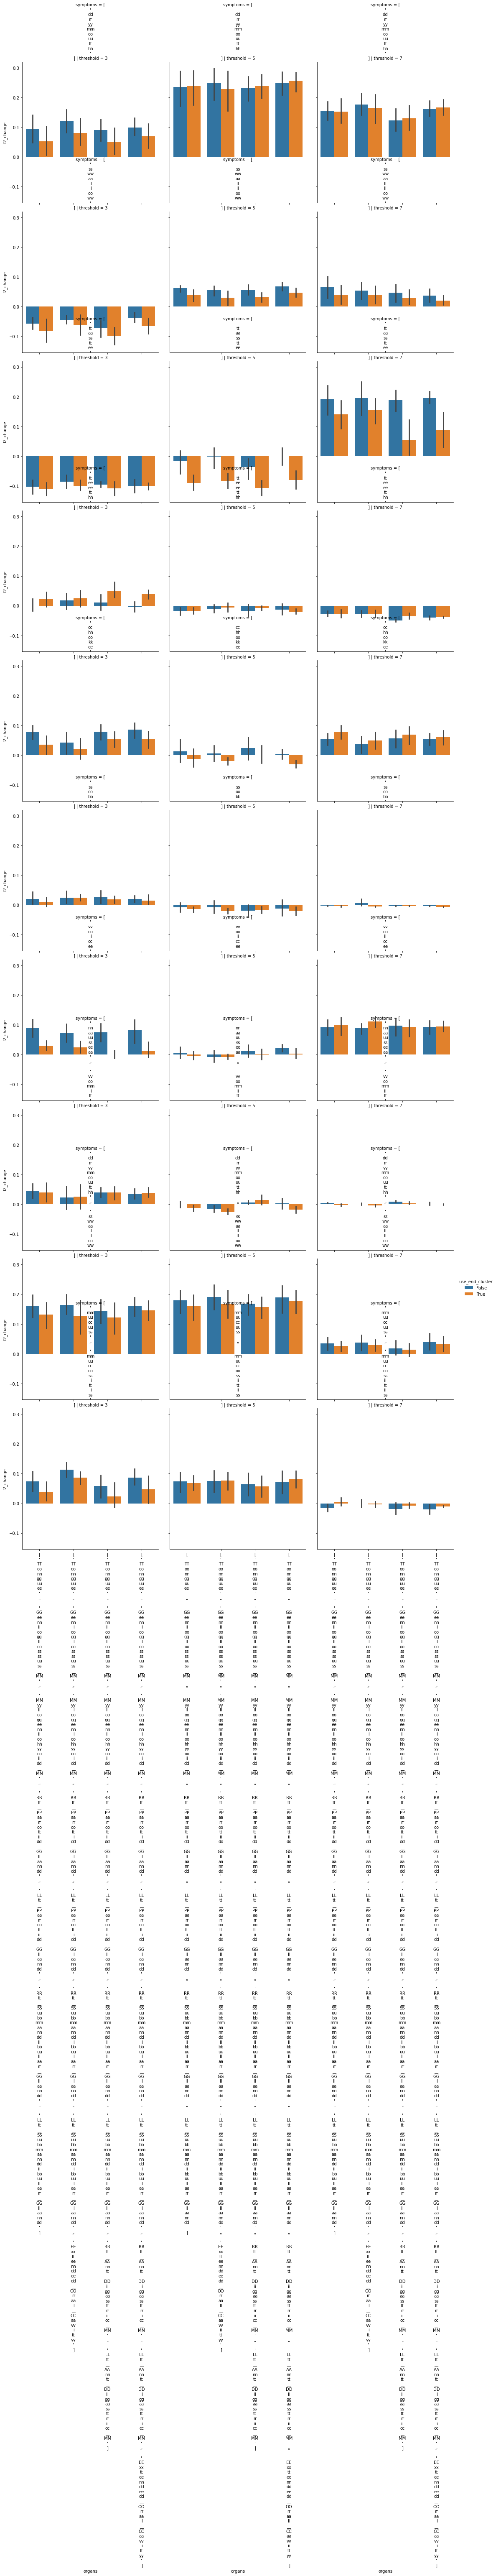

In [932]:
plot_auc_results(test,y='f2_change',hue='use_end_cluster',n_clusters=4,x='organs')

_____________


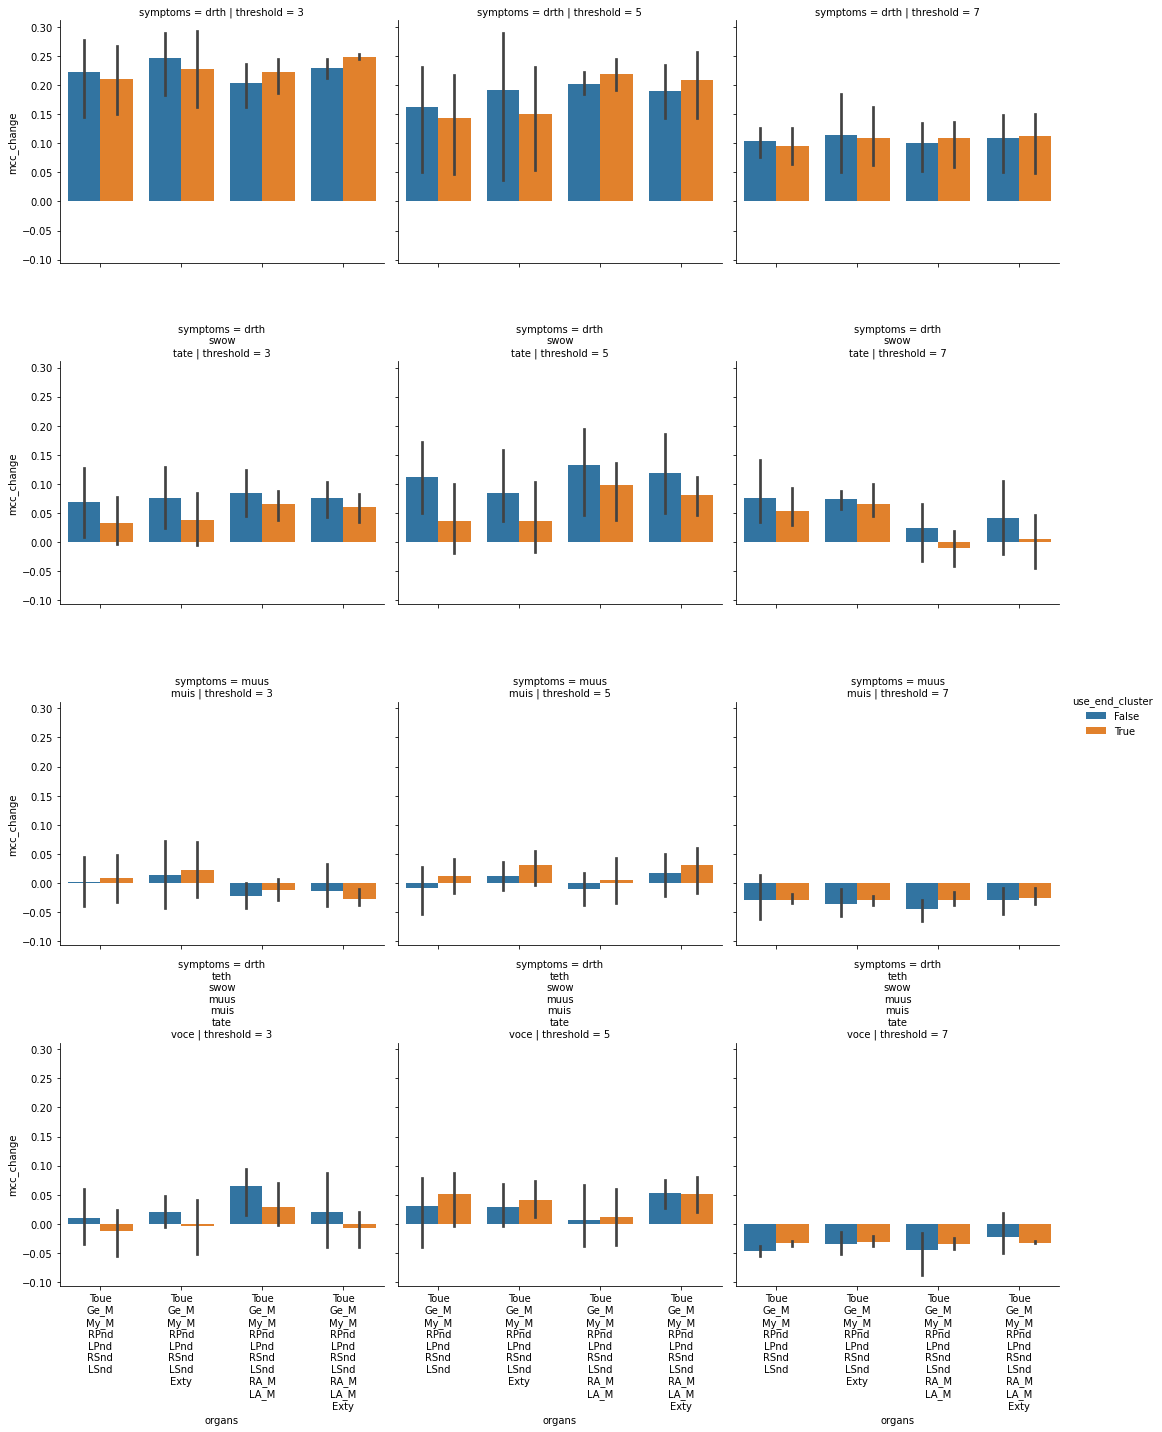

In [872]:
plot_auc_results(test,y='mcc_change',hue='use_end_cluster',x='organs')

_____________


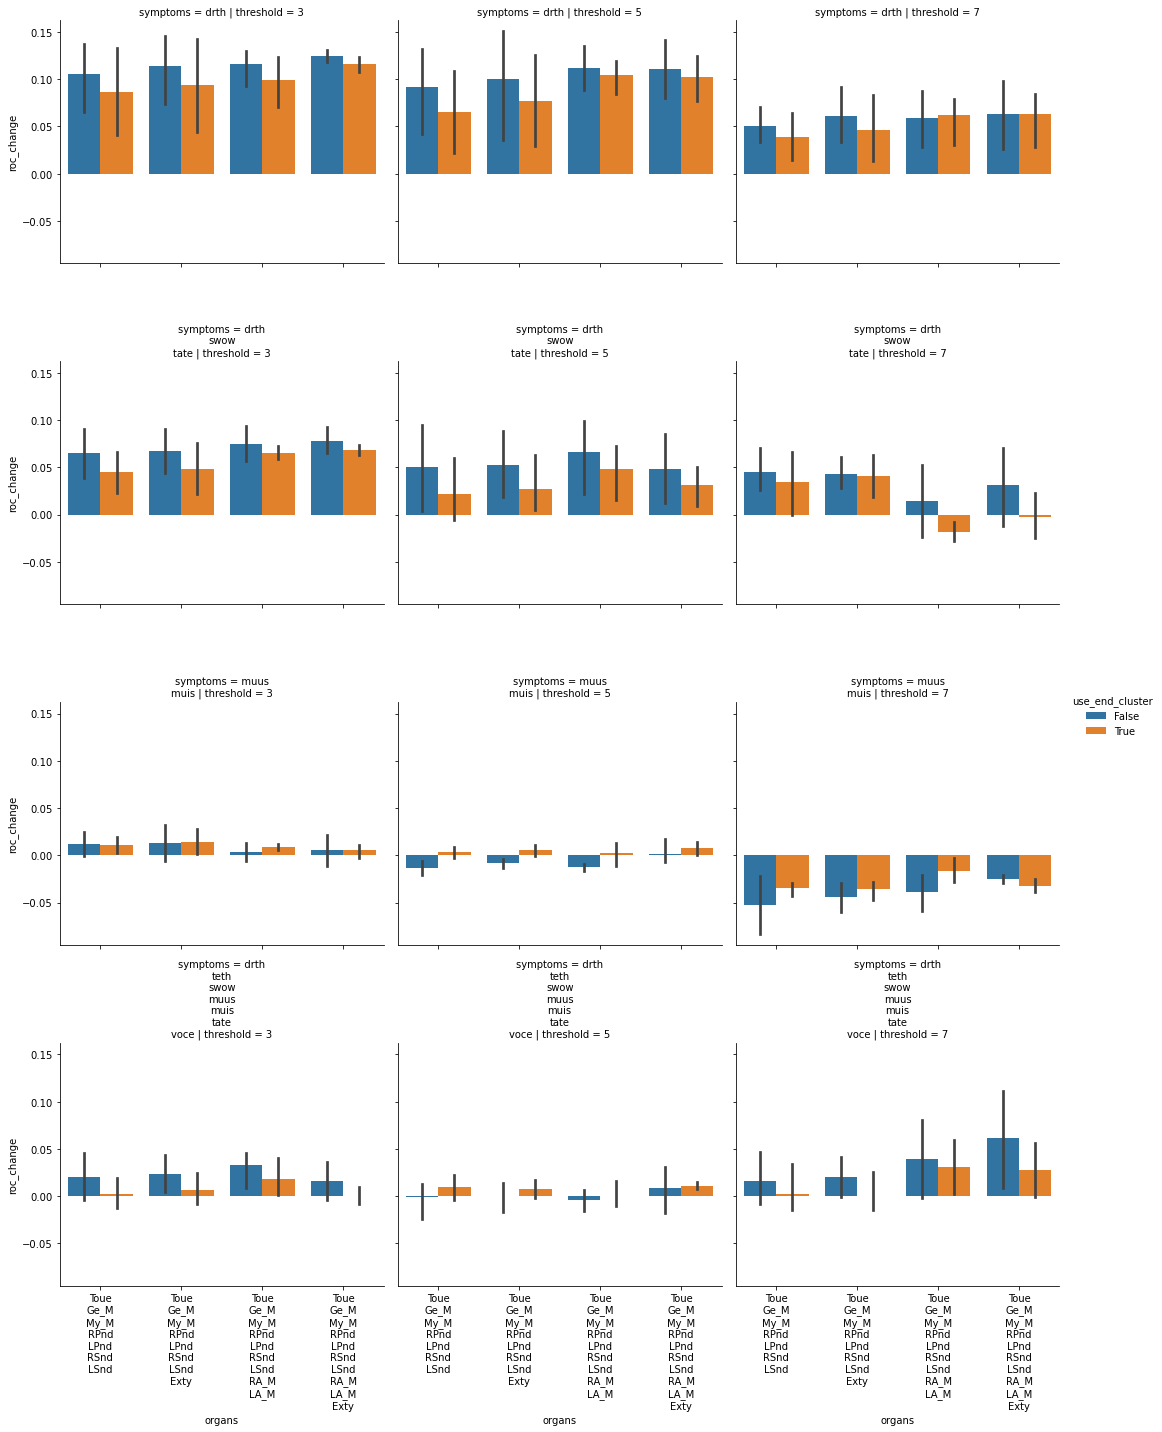

In [871]:
plot_auc_results(test,y='roc_change',hue='use_end_cluster',x='organs') 

In [722]:
res = ct.get_ate(n_iters=50,confounder_pval_filter=1,use_dose_confounders=False)
res.sort_values('dr_ate_05',ascending=False)

,threshold,cluster_value,iptw_ate_05,iptw_ate_median,iptw_ate_95,iptw_ate_sig,iptw_ate_positive,dr_ate_05,dr_ate_median,dr_ate_95,dr_ate_sig,dr_ate_positive
2,3,3,0.408604,0.552096,0.727930,True,True,-0.040037,0.003646,0.078701,False,False
8,7,3,0.106757,0.245100,0.385854,True,True,-0.055538,0.011940,0.072638,False,False
5,5,3,0.231729,0.409902,0.608627,True,True,-0.063917,0.013898,0.101525,False,False
1,3,2,1.725374,1.929877,2.350291,True,True,-0.067800,0.011618,0.083276,False,False
7,7,2,0.533637,0.820815,1.086907,True,True,-0.093643,0.004567,0.071750,False,False
3,5,1,1.923203,2.540091,3.103105,True,True,-0.117239,-0.022946,0.084169,False,False
0,3,1,2.857177,3.672307,4.318281,True,True,-0.117439,-0.030081,0.103841,False,False
4,5,2,1.031292,1.381203,1.724711,True,True,-0.118254,0.006471,0.099522,False,False
6,7,1,0.897052,1.414370,1.966374,True,True,-0.124270,-0.022385,0.063677,False,False


In [807]:
get_demographics_table(sddf)

is_male:
False : 36 (10.3%)
True : 313 (89.7%)
______
t_stage:
t0 : 30 (8.6%)
t1 : 105 (30.1%)
t2 : 128 (36.7%)
t3 : 43 (12.3%)
t4 : 34 (9.7%)
tx : 2 (0.6%)
______
n_stage:
n0 : 23 (6.6%)
n1 : 111 (31.8%)
n2 : 2 (0.6%)
n2a : 27 (7.7%)
n2b : 134 (38.4%)
n2c : 36 (10.3%)
n3 : 7 (2.0%)
nx : 2 (0.6%)
______
hpv:
-1.0 : 51 (14.6%)
0.0 : 25 (7.2%)
1.0 : 273 (78.2%)
______
ic:
0.0 : 239 (68.5%)
1.0 : 57 (16.3%)
2.0 : 1 (0.3%)
______
rt:
1.0 : 338 (96.8%)
______
chemotherapy:
00:00:00 : 1 (0.3%)
concurrent_chemotherapy : 247 (70.8%)
induction+concurrent : 35 (10.0%)
induction_RT : 11 (3.2%)
no_chemotherapy : 37 (10.6%)
______
os:
0 : 14 (4.0%)
1 : 317 (90.8%)
______


,mean,std,q05,median,q95
age,59.204023,11.390187,45.0,60.0,73.0
followup_days,803.557994,442.367340,121.5,770.0,1514.5


In [205]:
def run_ate_grid_search(savepath = None):
    if savepath is None:
        savepath = Const.data_dir+'cluster_ate_results_' + timestamp + '.csv'
    organs_of_interest_list = [
        ['Tongue','Genioglossus_M',
         'Rt_Parotid_Gland','Lt_Parotid_Gland',
         'Rt_Submandibular_Gland','Lt_Submandibular_Gland'],
        ['Tongue','Genioglossus_M','Mylogeniohyoid_M',
         'Rt_Parotid_Gland','Lt_Parotid_Gland',
         'Rt_Submandibular_Gland','Lt_Submandibular_Gland'],
    ]
    symptomlist = [
        ['drymouth'],
        ['taste'],
        ['voice'],
        ['nausea'],
        ['choke'],
        ['mucus'],
        ['teeth'],
        ['drymouth','voice','taste','teeth'],
        ['choke','nausea']
    ]
    results = []
    for symptoms in symptomlist:
        for organs_of_interest in organs_of_interest_list:
            try:
                ct = ClusterTester(sddf,organs_of_interest,symptoms=symptoms)
                ate_base = ct.get_ate(n_iters=50,confounder_pval_filter = 1, use_dose_confounders=False)
                ate_alt = ct.get_ate(n_iters=50)
                ate_base['symptoms'] = '_'.join(symptoms)
                ate_alt['symptoms'] = '_'.join(symptoms)
                ate_alt['use_dose'] = False
                ate_base['use_dose'] = True
                ate_alt['organs'] = organs
                ate_base['organs'] = organs
                results.append(ate_base)
                results.append(ate_alt)
                temp = pd.concat(results,axis=0,ignore_index=True)
                temp.to_csv(savepath)
                print(temp.sort_values('dr_ate_05',ascending=False).head())
            except Exception as e:
                print(e)
    return pd.concat(results,axis=0,ignore_index=True)

202228153957284759
202228153957284798
202228153957284810
202228153957284823
202228153957284835
202228153957284848
202228153957284859
202228153957284871
202228153957284883
202228153957284901
